In [15]:
from src import simulations, model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json

log_theta = pd.read_csv("results/paad/paad_muts_30_5_008_old.csv", index_col=0)
tau1, tau2 = np.exp(log_theta.pop("Sampling").iloc[:2])
events = log_theta.columns
log_theta = log_theta.to_numpy()


In [16]:
data = np.load("simulations/paad_muts_30_5_008_old.npy")


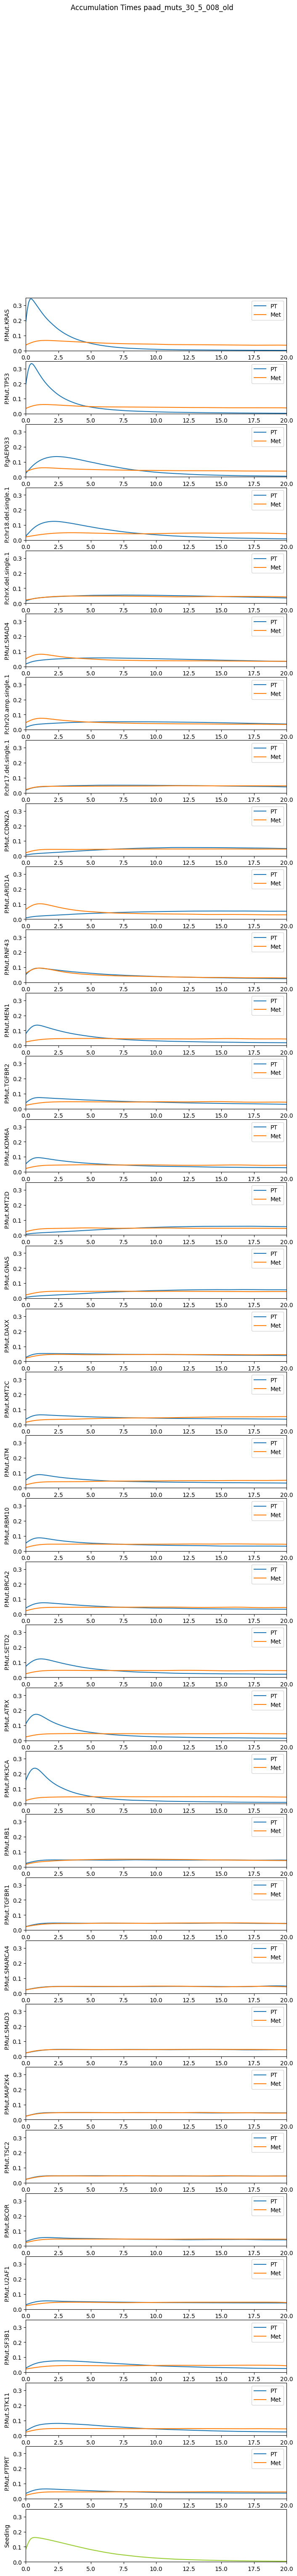

In [18]:
import seaborn as sns
f, a = plt.subplots(log_theta.shape[0], figsize=(8, 70))
lim = 20
for i in range(log_theta.shape[0] - 1):
    a[i].set_ylim((0, 0.35))
    a[i].set_xlim((0, lim))
    a[i].set_ylabel(events[i])
    sns.kdeplot(
        np.array(data[:, i][data[:, i] < lim * 1.1]), ax=a[i], label="PT")
    sns.kdeplot(np.array(data[:, i + len(log_theta) - 1][data[:,
                i + len(log_theta) - 1] < lim * 1.1]), ax=a[i], label="Met")
    a[i].legend()
a[-1].set_ylim((0, 0.35))
a[-1].set_xlim((0, lim))
a[-1].set_ylabel(events[-1])
sns.kdeplot(np.array(data[:, -1][data[:, -1] < lim * 1.1]),
            ax=a[-1], color="yellowgreen")
f.suptitle("Accumulation Times paad_muts_30_5_008_old")
f.savefig(dpi=200, fname="viz/accumulation_times.png")


In [5]:
means = data.mean(axis=0)


In [70]:
metMHN = model.MetMHN(log_theta=log_theta, tau1=tau1, tau2=tau2, events=events)
state = np.zeros(log_theta.shape[0], dtype=int)
state[[0, 2, 4, 12]] = 1
_, order = metMHN.likeliest_order(state, met=False)
order


array([ 0,  4, 12,  2])

In [71]:
# order = np.array([11, 16, 21])
# order = np.array([11, 16, 29])
# order = np.array([
#     5,
#     0,
#     1,
#     20
#     ])
# order = np.array([
#     5,
#     0,
#     1,
#     7,
#     # 2, 3
#     ])
events[order]


Index(['P.Mut.KRAS', 'P.chrX.del.single.1', 'P.Mut.TGFBR2', 'P.gAEP033'], dtype='object')

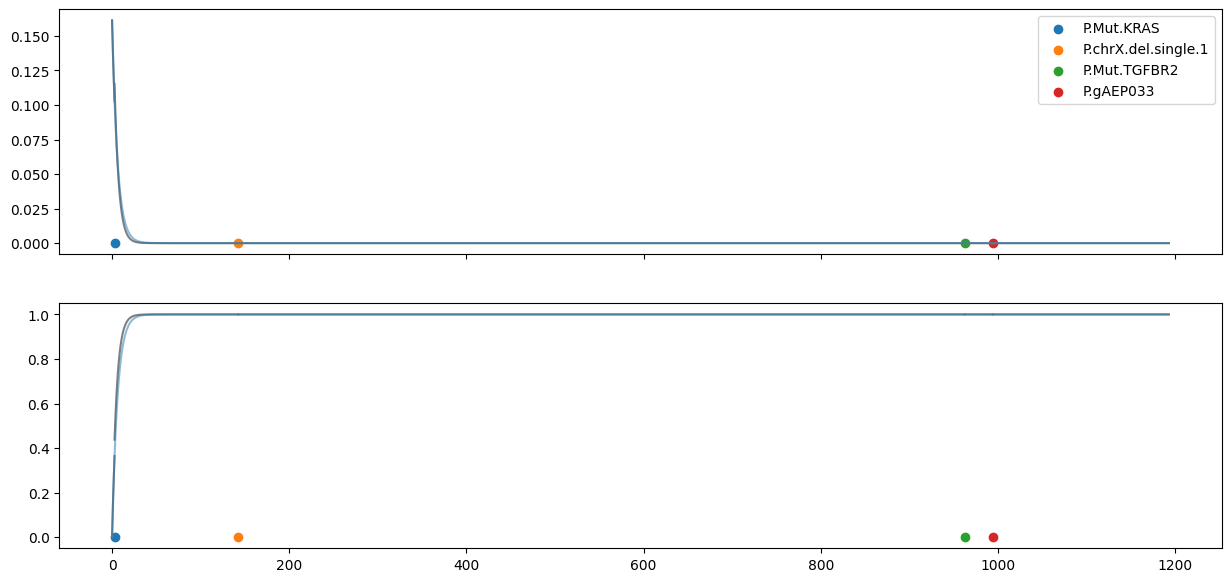

In [75]:
f, a = plt.subplots(2, figsize=(15, 7), sharex=True)
x = np.linspace(0, 5, 100)
rates = np.exp(np.tril(log_theta[np.ix_(order, order)]).sum(axis=1))
times = [(1 / rates[: i + 1]).sum() for i in range(len(order))]
times.append(0)
seeding = log_theta[-1, np.concatenate([np.array([-1]), order])]
for i, event in enumerate(order):
    a[0].scatter(times[i], 0, label=events[event])
    a[1].scatter(times[i], 0, label=events[event])
for i in range(len(order)):
    x = np.arange(0, 1/rates[i], 0.0001) + times[i-1]
    lam = np.exp(seeding[:i+1].sum())
    a[0].plot(x, lam * np.exp(-lam * x), color="grey")

    x = np.arange(times[i-1], times[i], 0.0001)
    a[1].plot(x, 1 - np.exp(-lam * x), color="grey")

x = np.arange(times[-2], 1.2 * times[-2], 0.0001)
lam = np.exp(seeding[:-1].sum())
a[0].plot(x, lam * np.exp(-lam * (x)), color="grey")

x = np.arange(times[-2], 1.2 * times[-2], 0.0001)
a[1].plot(x, 1 - np.exp(-lam * x), color="grey")
a[0].legend()
x = np.arange(0, 1.2 * times[-2], 0.0001)
lam = np.exp(seeding[0])
a[0].plot(x, lam * np.exp(-lam*x), alpha=0.5)
a[1].plot(x, 1 - np.exp(-lam*x), alpha=0.5)
